# Clasificador de Vinos con KNN
Entrena un modelo de K-Vecinos más Cercanos (KNN) para predecir la calidad de un vino tinto a partir de sus características químicas. ¿Podría una IA ayudarte a elegir un vino digno de sommelier?

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
from scipy.stats import randint
# To save models
import json
import pickle

import warnings
warnings.filterwarnings('ignore')

In [53]:
df_ini = pd.read_csv('../data/raw/winequality-red.csv', sep=';')
df_ini.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [54]:
df_ini.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [55]:
df= df_ini.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


> Al eliminar duplicados me quedo con 1359 entradas cuando teniamos 1599.

## Variables númericas

> Creo mapa de calor de > de 0,40 para ver las más correlacionadas y eliminar columnas.

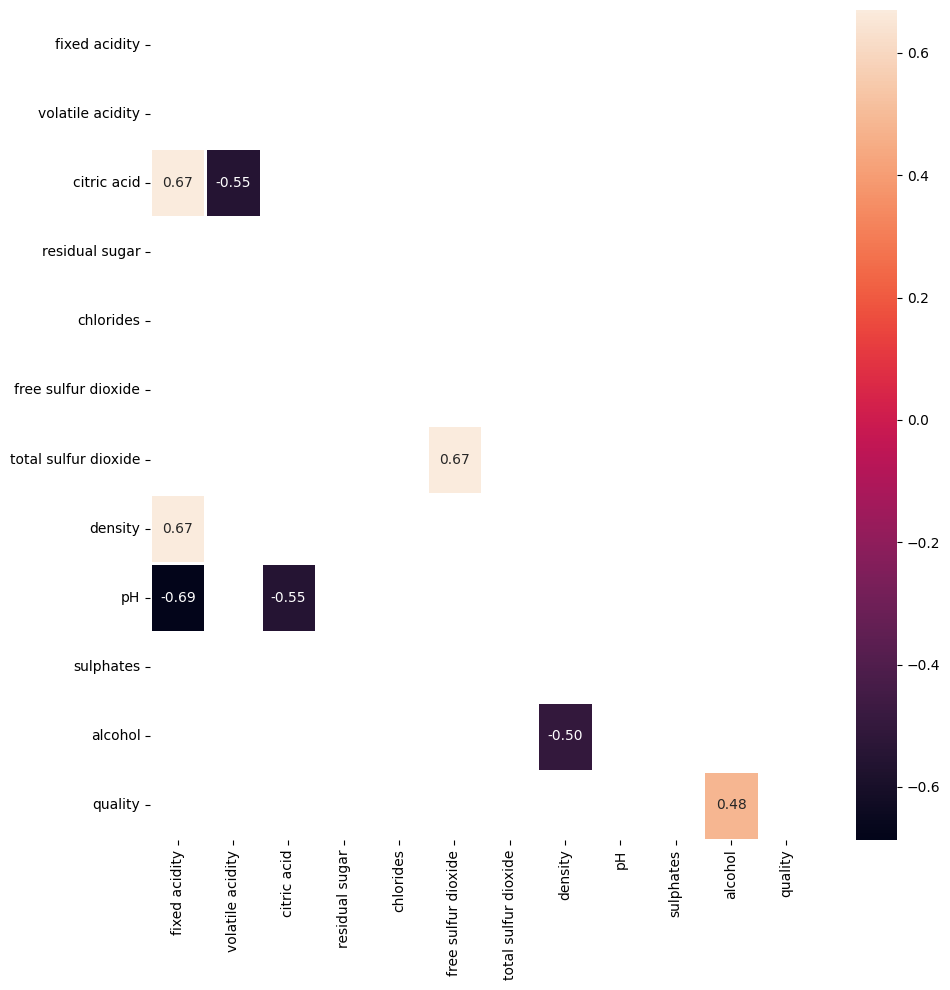

In [56]:
corr = df.corr()
high_correlation = corr[corr.abs() > 0.40]
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axis = plt.subplots(figsize=(10,10))
sns.heatmap(high_correlation, annot=True, mask=mask, linewidths=1, fmt=".2f")

plt.tight_layout()
plt.show()

> Elimino las variables que estan más correlacionadas entre sí.

In [57]:
columns_drop = ['citric acid', 'density', 'pH', 'free sulfur dioxide']
                
df.drop(columns_drop, axis=1, inplace=True)

df.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.70,1.9,0.076,34.0,0.56,9.4,5
1,7.8,0.88,2.6,0.098,67.0,0.68,9.8,5
2,7.8,0.76,2.3,0.092,54.0,0.65,9.8,5
3,11.2,0.28,1.9,0.075,60.0,0.58,9.8,6
5,7.4,0.66,1.8,0.075,40.0,0.56,9.4,5


> Miro que datos tengo en la columna target (quality) para poderlo segregar en 3 categorías tal como indica el ejercicio. Donde sea:
> - 0= Baja calidad
> - 1 = Calidad media
> - 2 = Alta calidad

In [58]:
df.value_counts('quality')

quality
5    577
6    535
7    167
4     53
8     17
3     10
Name: count, dtype: int64

In [59]:
# Defino la nueva columna
df['quality_segment'] = -1  

# Calidad Baja: 3 y 4 -> 0
df.loc[df['quality'].isin([3, 4]), 'quality_segment'] = 0

# Calidad Media: 5 y 6 -> 1
df.loc[df['quality'].isin([5, 6]), 'quality_segment'] = 1

# Calidad Alta: 7 y 8 -> 2
df.loc[df['quality'].isin([7, 8]), 'quality_segment'] = 2

# Elimino la columna 'quality' original
df = df.drop(columns=['quality'])

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   residual sugar        1359 non-null   float64
 3   chlorides             1359 non-null   float64
 4   total sulfur dioxide  1359 non-null   float64
 5   sulphates             1359 non-null   float64
 6   alcohol               1359 non-null   float64
 7   quality_segment       1359 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 95.6 KB


## Split

In [61]:
X = df.drop('quality_segment', axis=1)
y = df['quality_segment']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

## Scaling

In [62]:
norm_scaler = StandardScaler()  

num_variables = ['fixed acidity', 'volatile acidity', 'residual sugar','chlorides','total sulfur dioxide', 
                'sulphates','alcohol']

norm_train = norm_scaler.fit_transform(X_train[num_variables])
norm_test = norm_scaler.transform(X_test[num_variables])


## Modelo KNN Clasificación

In [63]:
# Modelo
model = KNeighborsClassifier()

# Entrenamiento
model.fit(norm_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [64]:
# Predicción
y_pred_test = model.predict(norm_test)
y_pred_train = model.predict(norm_train)


In [65]:
accuracy = {'Accuracy Test': accuracy_score(y_test, y_pred_test),
            'Accuracy Train': accuracy_score(y_train, y_pred_train)}
accuracy

{'Accuracy Test': 0.8419117647058824, 'Accuracy Train': 0.8721251149954001}

### Hiperparametrización

In [66]:
hiper_params = {'n_neighbors': [11, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]}